In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import sys
import os
import platform
import itertools

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [3]:
user_vimms = "vimms"
sys.path.append(user_vimms)

In [4]:
mzmine_path = os.path.join("MZmine-2.53-Windows", "startMZmine-Windows.bat")
old_mzmine = False
template_suffix = "_old" if old_mzmine else ""
mzmine_template = os.path.join(user_vimms, "batch_files", f"multi_sample_peak_pick{template_suffix}.xml")

In [5]:
from vimms.Common import (
    POSITIVE, load_obj,
    set_log_level_warning,
)
from vimms.Experiment import Experiment
from vimms.BoxVisualise import (
    mpl_set_axis_style, mpl_set_figure_style,
    mpl_results_plot, plotly_results_plot,
    plotly_timing_hist, seaborn_timing_hist,
    mpl_fragmentation_events, plotly_fragmentation_events,
    mpl_fragmented_boxes,
    seaborn_uncovered_area_hist,
    BoxViewer
)

/datastore/home1/2185647m/topNEXt_experiments/topNEXt_experiments/vimms/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
ionisation_mode = POSITIVE
pbar = False
set_log_level_warning()

1

In [7]:
#multi_dir = "/Users/%s/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Experimental_Results/20220706_DDAvsDIA" % user
multi_dir = "20220719_multi_samples_main"
multibeer_dir = os.path.join(multi_dir, "results_4")

In [8]:
num_workers = 8 #can't always use number of physical cores because of memory constraints

In [9]:
def load_pkls(pickle_dir, case_names, repeat, load_rois=False):
    exp_pkls = {}
    for case_name in case_names:
        roi_str = "_rois" if load_rois else ""
        exp_pickle_paths = [f"{os.path.join(pickle_dir, case_name)}_{i}{roi_str}.pkl" for i in range(repeat)]
        exp_pkls[case_name] = [load_obj(pkl) for pkl in exp_pickle_paths]
    return exp_pkls

In [10]:
mpl_colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colour_iterator = itertools.cycle(mpl_colours)
colour_map = {
    "topN" : mpl_colours[5],
    "topN_RoI" : mpl_colours[7],
    "topN_exclusion" : mpl_colours[1],
    "topNEx" : mpl_colours[2],
    "hard_roi_exclusion" : mpl_colours[0],
    "intensity_roi_exclusion" : mpl_colours[8],
    "non_overlap" : mpl_colours[6],
    "intensity_non_overlap" : mpl_colours[3],
    
}

def update_cmap(name):
    if(not name in colour_map):
        colour_map[name] = next(mpl_colours)
    return colour_map[name]

def get_style(name):
    if(name.lower().endswith("smartroi")):
        c = update_cmap("_".join(name.split("_")[:-1]))
        return c, "v"
    elif(name.lower().endswith("weighteddew")):
        c = update_cmap("_".join(name.split("_")[:-1]))
        return c, "^"
    else:
        c = update_cmap(name)
        return c, "o"
    
def get_line_styles(case_names):
    colours, markers = [], []
    for case_name in case_names:
        c, m = get_style(case_name)
        colours.append(c)
        markers.append(m)
    return colours, markers

In [11]:
name_map = {
    "topN" : "TopN",
    "topN_RoI" : "TopN RoI",
    "topN_exclusion" : "TopN Exclusion",
    "topNEx" : "TopNEx",
    "hard_roi_exclusion" : "Hard RoI Exclusion",
    "intensity_roi_exclusion" : "Intensity RoI Exclusion",
    "non_overlap" : "Non-Overlap",
    "intensity_non_overlap" : "Intensity Non-Overlap",
    
}

markersize = 11

legend_elements = [
    Line2D([0], [0], marker="o", color="black", label="Standard DEW", markerfacecolor="black", markersize=markersize),
    Line2D([0], [0], color="white", label="", markerfacecolor="black", markersize=markersize),
]
    
for name in ["topN_exclusion", "intensity_non_overlap"]:
    legend_elements.append(
        Line2D([0], [0], marker="s", color="white", label=name_map[name], markerfacecolor=colour_map[name], markersize=14)
    )

In [12]:
fig_kwargs = {
    "tick_kwargs" : {
        "width" : 2.5,
        "length" : 12,
        "labelsize" : 22,
    },
    
    "axis_borderwidth" : 2.5,
    
    "axis_kwargs" : {
        "labelsize" : 24,
        "titlesize" : 24,
        "linewidth" : 1.5,
        "markersize" : 6,
        "legend_kwargs" : {
            "handles" : legend_elements,
            "fontsize" : 13
        }
    },
    
    "suptitle" : "Default Suptitle",
    "suptitle_size" : 18,
    "figure_sizes" : (18, 8),
}

# 1. Same Beer Repeated Multiple Times

### Evaluate

In [13]:
repeat = 20
out_dir = "reoptimised_same_beer"

same_case_names = [
    "topN_exclusion",
    "intensity_non_overlap"
]

line_colours, line_markers = get_line_styles(same_case_names)

In [14]:
same_beer_exp = Experiment.load_from_json(
    file_dir = out_dir,
    file_name = "keyfile.json",
    out_dir = out_dir,
    fullscan_dir = multibeer_dir,
    amend_result_path = True,
    case_names = same_case_names
)

In [15]:
isolation_width = 1.0
true_repeat = min(
    repeat,
    len(same_beer_exp.case_mzmls[same_beer_exp.case_names[0]])
)

same_beer_exp.evaluate(
    num_workers = num_workers,
    isolation_widths = isolation_width,
    max_repeat = repeat,
    aligned_names = f"multibeers_1_{true_repeat}" + template_suffix,
    mzmine_templates = mzmine_template,
    mzmine_exe = mzmine_path,
    force_peak_picking = False
)

same_beer_exp.summarise(num_workers=num_workers, rank_key="cumulative_intensity_proportion")

2025 aligned boxes contained in file
2025 aligned boxes contained in file

intensity_non_overlap
Number of fragmentations: [6409, 6417, 6292, 6254, 6255, 6189, 6201, 6179, 6128, 6170, 6171, 6123, 6105, 6095, 5954, 6127, 6167, 6108, 6099, 6062]
Cumulative coverage: [1141, 1564, 1696, 1759, 1794, 1819, 1830, 1838, 1844, 1852, 1859, 1862, 1863, 1867, 1871, 1873, 1874, 1874, 1874, 1875]
Cumulative coverage proportion: [0.5839303991811668, 0.8004094165813715, 0.8679631525076765, 0.9002047082906858, 0.9181166837256909, 0.9309109518935517, 0.9365404298874105, 0.9406345957011258, 0.9437052200614124, 0.9477993858751279, 0.951381780962129, 0.9529170931422722, 0.9534288638689867, 0.9554759467758445, 0.9575230296827022, 0.9585465711361311, 0.9590583418628454, 0.9590583418628454, 0.9590583418628454, 0.9595701125895599]
Cumulative intensity proportion: [0.3379565146231265, 0.5528242261810363, 0.6488909357019274, 0.6972476374713796, 0.7230306055348039, 0.7513092762565138, 0.7640178246005801, 0.779427

### Plot

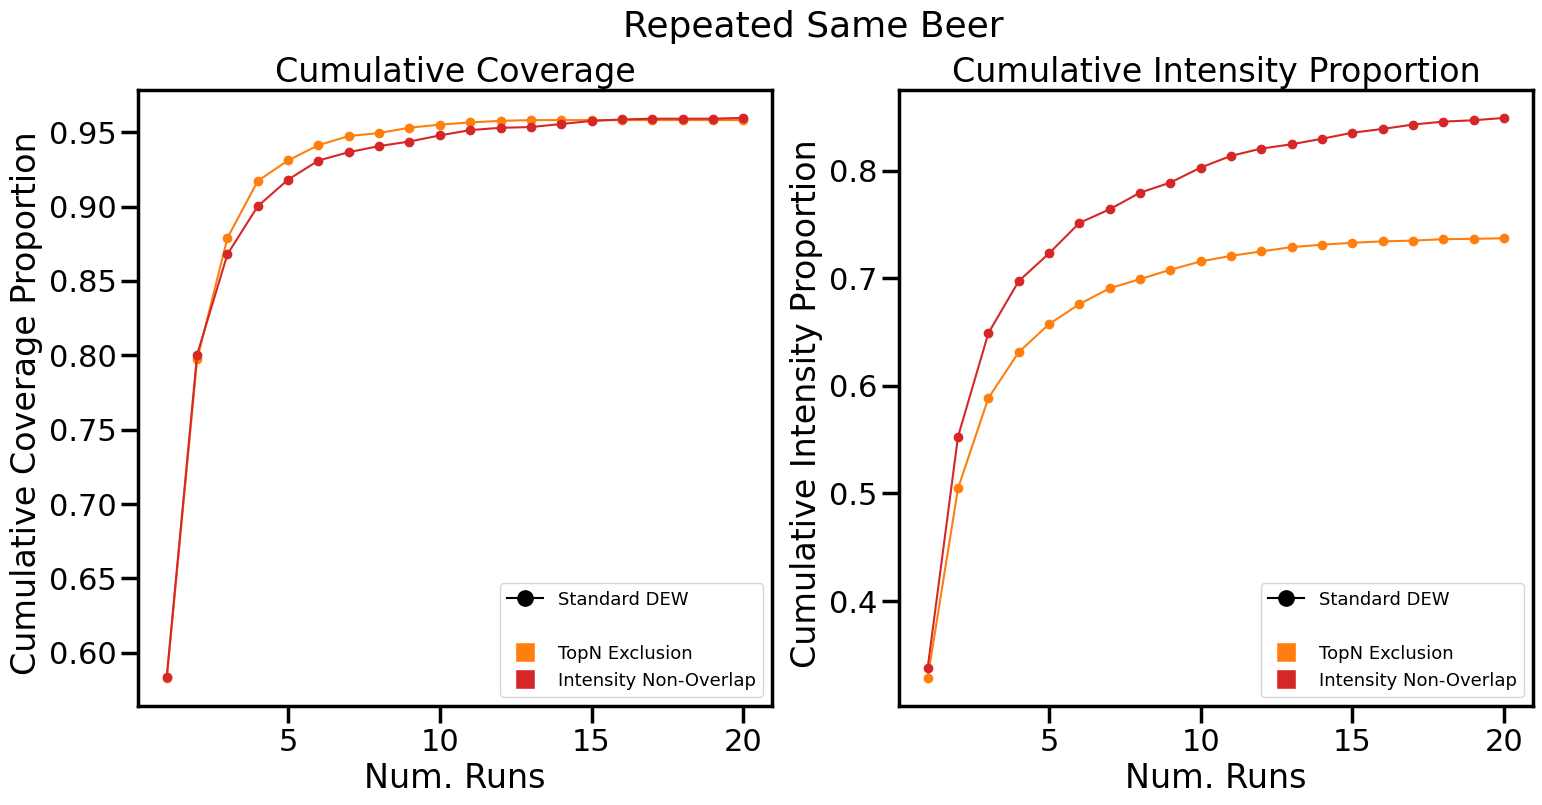

In [16]:
#non-interactive plot, but is just an image so will persist if notebook is refreshed
fig, axes = mpl_results_plot(
    same_case_names,
    same_beer_exp.evaluators,
    min_intensity=0.0,
    colours=line_colours,
    markers=line_markers,
    mode="absolute"
)

mpl_set_figure_style(fig, **{**fig_kwargs, "suptitle" : "Repeated Same Beer", "suptitle_size" : 26})
mpl_set_axis_style(axes[1], legend_kwargs={**fig_kwargs["axis_kwargs"]["legend_kwargs"], "loc" : "lower right"})

# 3. Repeating Different Beers

In [17]:
bio_repeat = 6
tech_repeat = 4
repeat = bio_repeat * tech_repeat
out_dir = "reoptimised_repeated_different_beer"

rep_diff_case_names = [
    "topN_exclusion",
    "intensity_non_overlap"
]

line_colours, line_markers = get_line_styles(rep_diff_case_names)

In [18]:
rep_diff_beer_exp = Experiment.load_from_json(
    file_dir = out_dir,
    file_name = "keyfile.json",
    out_dir = out_dir,
    fullscan_dir = multibeer_dir,
    amend_result_path = True,
    case_names = rep_diff_case_names
)

In [19]:
isolation_width = 1.0
rep_diff_beer_exp.evaluate(
    num_workers = num_workers,
    isolation_widths = isolation_width,
    max_repeat = repeat,
    aligned_names = f"multibeers_{bio_repeat}_{tech_repeat}" + template_suffix,
    mzmine_templates = mzmine_template,
    mzmine_exe = mzmine_path,
    force_peak_picking = False
)

rep_diff_beer_exp.summarise(num_workers=num_workers, rank_key="cumulative_intensity_proportion")

6415 aligned boxes contained in file
6415 aligned boxes contained in file

intensity_non_overlap
Number of fragmentations: [6409, 6453, 6475, 6397, 6410, 6347, 6356, 6308, 6373, 6349, 6338, 6345, 6255, 6302, 6319, 6279, 6302, 6284, 6282, 6291, 6309, 6277, 6243, 6338]
Cumulative coverage: [1141, 2663, 3196, 3745, 4016, 4421, 4609, 4881, 4941, 5034, 5105, 5192, 5239, 5367, 5399, 5440, 5472, 5492, 5510, 5593, 5611, 5630, 5642, 5665]
Cumulative coverage proportion: [0.18418079096045198, 0.429862792574657, 0.5158999192897498, 0.6045197740112994, 0.6482647296206618, 0.7136400322841001, 0.7439870863599677, 0.7878934624697337, 0.7975786924939468, 0.812590799031477, 0.8240516545601292, 0.8380952380952381, 0.845682001614205, 0.8663438256658595, 0.8715092816787732, 0.8781275221953188, 0.8832929782082325, 0.8865213882163034, 0.8894269572235673, 0.9028248587570622, 0.9057304277643261, 0.9087974172719936, 0.9107344632768362, 0.9144471347861178]
Cumulative intensity proportion: [0.08133758893757026, 

### Plot

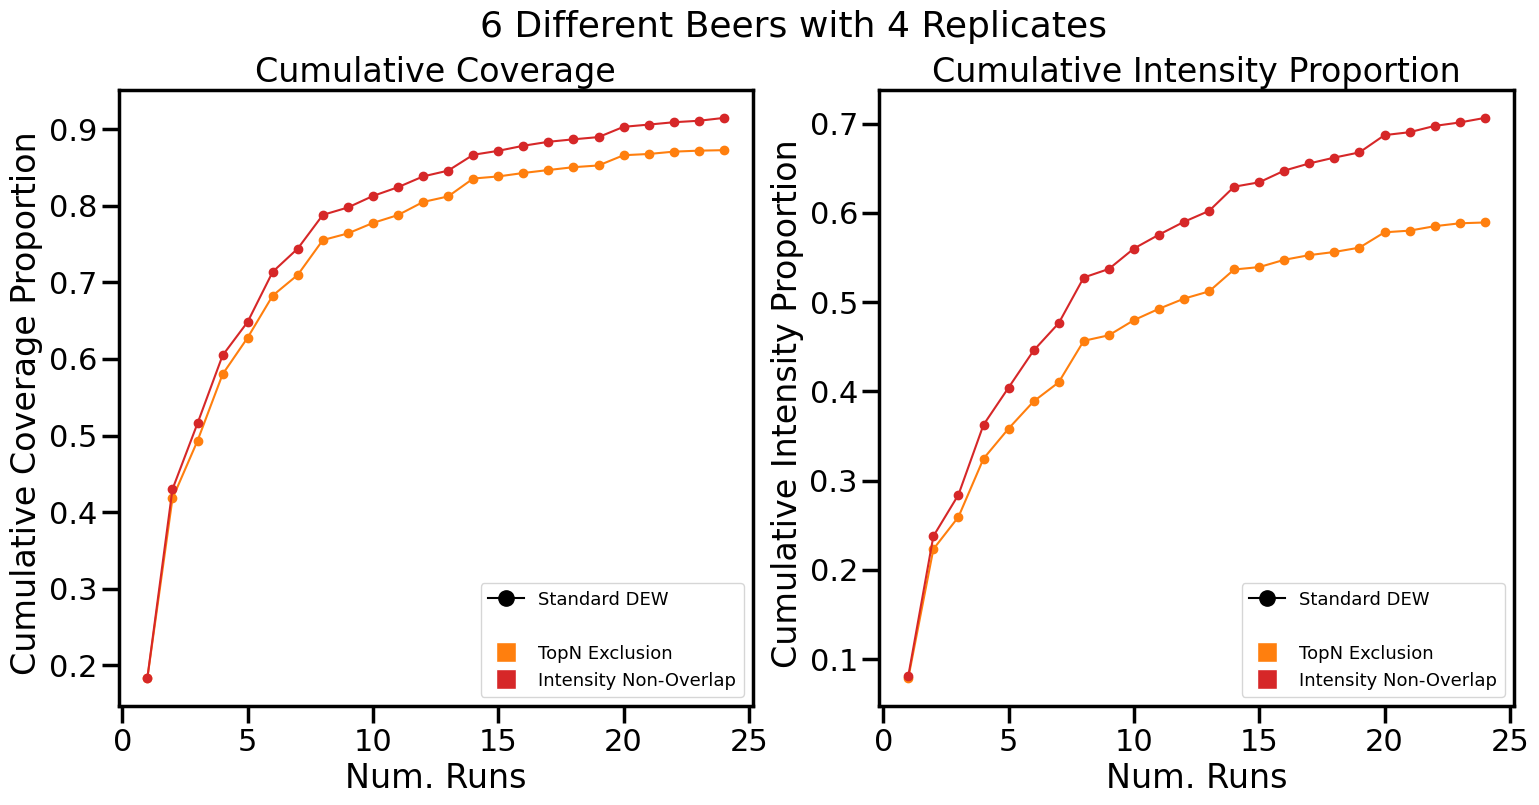

In [20]:
fig, axes = mpl_results_plot(
    rep_diff_case_names,
    rep_diff_beer_exp.evaluators,
    min_intensity=0.0,
    colours=line_colours,
    markers=line_markers,
)

kwargs = {
    **fig_kwargs, 
    "suptitle" : f"{bio_repeat} Different Beers with {tech_repeat} Replicates", 
    "suptitle_size" : 26
}
mpl_set_figure_style(fig, **kwargs)
mpl_set_axis_style(axes[1], legend_kwargs={**fig_kwargs["axis_kwargs"]["legend_kwargs"], "loc" : "lower right"})